In [1]:
#Importing the necessary libraries and ignore warnings 
import numpy as np 
import matplotlib.pyplot as plt
from landlab.components import SpaceLargeScaleEroder, PriorityFloodFlowRouter, DepthDependentDiffuser, ExponentialWeatherer, BedrockLandslider
from landlab import RasterModelGrid, imshowhs_grid, imshow_grid
from auxiliary_functions import (get_topo, smooth_elevation_grid) 
import warnings

warnings.filterwarnings('ignore') # ignore warning when running the code

In [2]:
"""
Importing topography from OpenTopography using bmi_topography, smoothing the elevation to get rid of artifacts and defining the topographic__elevation field. 
"""
dem_info = {
        'dem_type': "SRTMGL3",
        'north': 5.9454,
        'east': -75.8607,
        'south': 5.5595,
        'west': -76.2852,
        'buffer': 0.01,
        'smooth_num': 2
        }
grid, z = get_topo(dem_type=dem_info['dem_type'],
                north=dem_info['north'],south=dem_info['south'],
                east=dem_info['east'],west=dem_info['west'],
                buffer=dem_info['buffer']) # Smoothen downloaded DEM
smoothed_elev = smooth_elevation_grid(grid, method='gaussian', smooth_num=4) #function to smooth elevation

grid.at_node["topographic__elevation"] = smoothed_elev #defining the topographic__elevation field from the smoothed_elev

soil_depth = grid.add_zeros("node", "soil__depth", clobber=True)

# Set 2 m of initial soil depth at core nodes
grid.at_node["soil__depth"][grid.core_nodes] = 2.0  # meters

# Add field 'bedrock__elevation' to the grid
b = grid.add_zeros("bedrock__elevation", at="node", clobber=True)

# Sum 'soil__depth' and 'bedrock__elevation' to yield 'topographic elevation'
grid.at_node["bedrock__elevation"][:] = grid.at_node["topographic__elevation"]
grid.at_node["topographic__elevation"][:] += grid.at_node["soil__depth"]

grid.at_node["bedrock__elevation"]= grid.at_node["topographic__elevation"] - grid.at_node["soil__depth"]

{'dem_type': 'SRTMGL3', 'south': 5.5495, 'north': 5.9554, 'west': -76.29520000000001, 'east': -75.85069999999999, 'output_format': 'AAIGrid', 'cache_dir': PosixPath('/home/jupyter-m.wanderleydealmei-5aef5/ivy'), 'api_key': 'f08b2664772eb044626d5cb114924de1'}
<xarray.DataArray 'SRTMGL3' (band: 1, y: 487, x: 533)> Size: 1MB
[259571 values with dtype=int32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 4kB -76.3 -76.29 -76.29 ... -75.85 -75.85 -75.85
  * y            (y) float64 4kB 5.955 5.954 5.953 5.952 ... 5.552 5.551 5.55
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:    0
    scale_factor:  1.0
    add_offset:    0.0
    units:         unknown


In [3]:
grid.at_node['bedrock__elevation'][grid.core_nodes] - grid.at_node["topographic__elevation"][grid.core_nodes]

array([-2., -2., -2., ..., -2., -2., -2.], shape=(257535,))

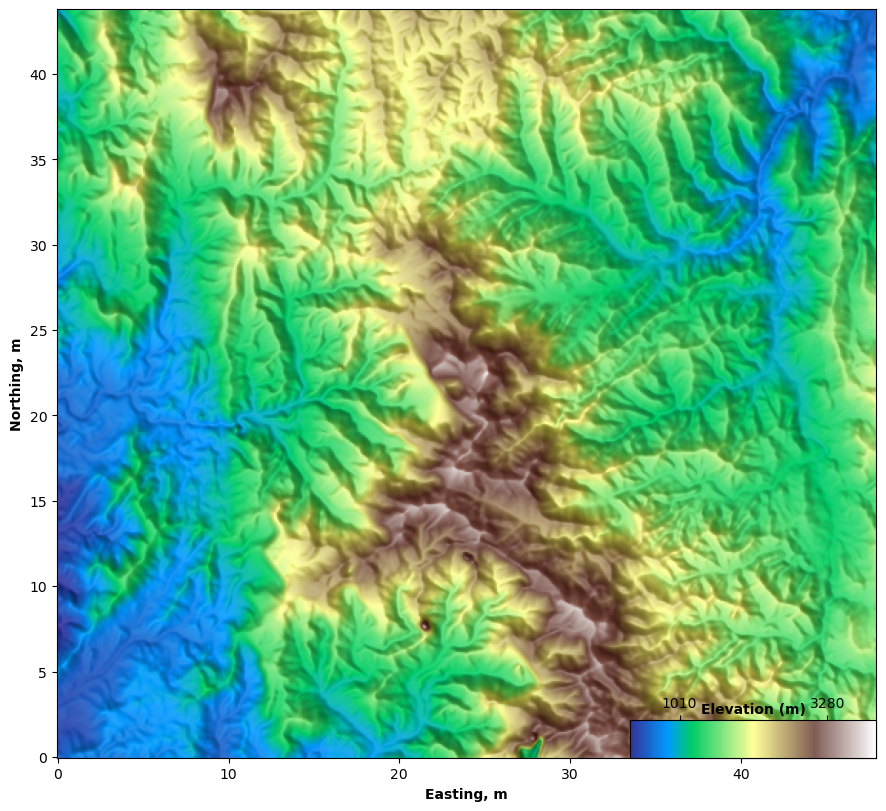

In [4]:
fig_DEM = plt.figure(figsize=(12,8), layout='constrained')

imshowhs_grid(grid, 'topographic__elevation', var_name='Elevation',
              var_units='m', ticks_km=True, cmap="terrain")
plt.show()

In [5]:
"""
Defining Uplift, parameters for SpaceLargeScaleEroder, DepthDependentDiffuser, and BedrockLandslider 
"""
#Uplift
U = 0.001

#Space parameters
K_sed=5e-5
K_br=5e-5
F_f=0
H_star=1
phi=0.3
v_s=1
v_s_lake=1
m_sp=0.5
n_sp=1
sp_crit_sed=0
sp_crit_br=0

#DepthDependentDiffuser parameters
linear_diffusivity=0.01
soil_transport_decay_depth=1.0

#BedrockLandslider parameters
angle_int_frict=0.15
cohesion_eff=np.ones_like(z) *1e6
landslides_return_time=100

In [6]:
"""
Defining time parameters
"""
dt = 50 # timestep
total_time = 2000 # total runtime 
n_dt = total_time/dt #calculate number of timesteps

In [7]:
pf = PriorityFloodFlowRouter(grid, surface="topographic__elevation",
                             flow_metric="D8", hill_flow_metric="Quinn",
                             depression_handler="fill",
                             update_hill_flow_instantaneous=True,
                             update_flow_depressions=True,
                             update_hill_depressions=True,
                             accumulate_flow=True,
                             accumulate_flow_hill=True,
                             separate_hill_flow=True,
                             suppress_out=True
                             )
pf.run_one_step()

# %%
# Instantiate SPACE model with chosen parameters
sp = SpaceLargeScaleEroder(grid, K_sed=K_sed,
                           K_br=K_br,
                           F_f=F_f,
                           phi=phi,
                           H_star=H_star,
                           v_s=v_s,
                           v_s_lake=v_s_lake,
                           m_sp=m_sp,
                           n_sp=n_sp,
                           sp_crit_sed=sp_crit_sed,
                           sp_crit_br=sp_crit_br,
                           )

ls = BedrockLandslider(grid,
                           angle_int_frict=angle_int_frict,
                           cohesion_eff=cohesion_eff,
                           landslides_return_time=landslides_return_time,
                           verbose_landslides=False,
                           landslides_on_boundary_nodes=False,
                           )

ew = ExponentialWeatherer(grid,
                          soil_production_decay_depth=1.0,
                          soil_production_maximum_rate=1.0
                         )

DDD = DepthDependentDiffuser(grid,
                             linear_diffusivity=linear_diffusivity,
                             soil_transport_decay_depth=soil_transport_decay_depth
                            )

In [8]:
ero_cumul=grid.add_zeros("ero_cumul", at='node')
depo_cumul= grid.add_zeros("depo_cumul", at='node')


for i in range(int(n_dt)):
    b += U * dt
    pf.run_one_step()
    sp.run_one_step(dt)
    print("Landsliding")
    ls.run_one_step(dt)
    ew.run_one_step()
    DDD.run_one_step(dt)

Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding
Landsliding


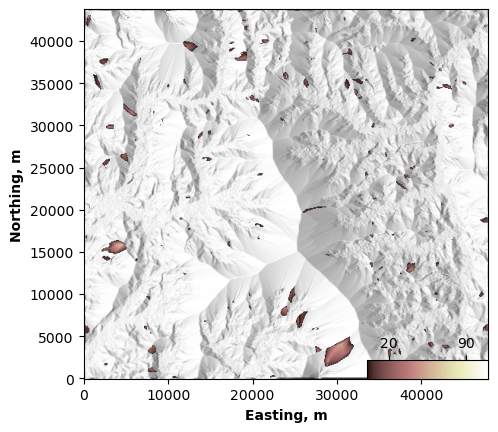

In [9]:
imshowhs_grid(grid, 'topographic__elevation', plot_type='Drape1',
              drape1=np.ma.masked_equal(grid.at_node['landslide__erosion'], 0),
             azdeg= 275)
plt.show()